# 1. Environment Setup

### 1.1 Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import re

import networkx as nx
from networkx.algorithms import bipartite as bi
from pyvis.network import Network
import community as community_louvain

from textblob import TextBlob
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim import models
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### 1.2 Load Data

In [2]:
df_orig = pd.read_csv(r"data/lyrics_raw.csv")
print(f'The dataframe has {len(df_orig)} observations.')
df_orig.head()

The dataframe has 530 observations.


,track_name,artist,raw_lyrics,artist_verses
0,You Broke My Heart,Drake,"Yeah Yeah Oh, baby, don't go Don't go Look Loo...","Yeah\nYeah\nOh, baby, don't go\nDon't go\nLook..."
1,First Person Shooter (feat. J. Cole),Drake,"[Intro: J. Cole & Adonis] (Pew, pew-pew) First...",Big as the what? (Ah)\nBig as the what? (Mm)\n...
2,MELTDOWN (feat. Drake),Drake,[Intro: Drake] Yeah Tensions is definitely ris...,Yeah\nTensions is definitely rising\nT'd up ri...
3,Slime You Out (feat. SZA),Drake,I don't know I don't know what's wrong with yo...,I don't know\nI don't know what's wrong with y...
4,On The Radar Freestyle,Drake,"Yeah On The Radar, 2023 6 G-O-D and my broski ...","Yeah\nOn The Radar, \n G-O-D and my broski \nC..."


# 2. Preprocess Data For Social Network Analysis
The biggest task for preprocessing this data for social network analysis was to extract the featured artists found in the track name. There were many variations of how to match the names using regex. The biggest one was by detecting 'feat.' followed by 'ft.' and some other variations.  

This was not a perfect solution, therefore 8 instances were extracted by assigning them manually.  

One artist had another spelling variation and was reconciled into the majority version.

In [3]:
# extract featured artists from 'track_name'. Flag words include ['ft.', 'with', 'feat.', 'featuring'] 
feat_df = df_orig[df_orig['track_name'].str.contains('feat.', case=False, na=False)]
len(feat_df)
#feat_df

149

### 2.1 Define Function for Extracting Featured Artist Names From Track Name

In [4]:
def extract_featured_artists(track_name, main_artist):
    '''Extracts artist names, and splits them into a list'''
    
    pattern = re.compile(r'\((ft\.|with|feat\.|featuring)\s(.*?)\)', re.IGNORECASE) #define re pattern
    matches = re.findall(pattern, track_name) #identify pattern matches
    featured_artists = [match[1] for match in matches] #split artists by comma
    featured_artists = [item.strip() for sublist in featured_artists for item in sublist.split(',')]
    
    featured_artists = [artist for artist in featured_artists if artist.lower() != main_artist.lower() and artist] # Remove any artist that is the main artist or empty strings
    
    return featured_artists

In [5]:
# Apply the function to each row in the DataFrame
df1 = df_orig.copy()
df1['featured_artists'] = df1.apply(lambda row: extract_featured_artists(row['track_name'], row['artist']), axis=1)

df1.head(2)

,track_name,artist,raw_lyrics,artist_verses,featured_artists
0,You Broke My Heart,Drake,"Yeah Yeah Oh, baby, don't go Don't go Look Loo...","Yeah\nYeah\nOh, baby, don't go\nDon't go\nLook...",[]
1,First Person Shooter (feat. J. Cole),Drake,"[Intro: J. Cole & Adonis] (Pew, pew-pew) First...",Big as the what? (Ah)\nBig as the what? (Mm)\n...,[J. Cole]


In [6]:
#Check empty lists in 'featured_artists'
empty_featured_df = df1[df1['featured_artists'].apply(lambda x: len(x) == 0)]
empty_featured_df[['track_name', 'artist', 'featured_artists']][:5]

,track_name,artist,featured_artists
0,You Broke My Heart,Drake,[]
2,MELTDOWN (feat. Drake),Drake,[]
4,On The Radar Freestyle,Drake,[]
6,Search & Rescue,Drake,[]
7,The Shoe Fits,Drake,[]


### 2.2 Manually extract lingering featured artists

In [7]:
df2 = df1.copy() 

df2.loc[203, 'featured_artists'] = df2.loc[203, 'featured_artists'] + ['Chris Brown']
df2.loc[162, 'featured_artists'] = df2.loc[162, 'featured_artists'] + ['Metro Boomin']
df2.loc[208, 'featured_artists'] = df2.loc[208, 'featured_artists'] + ['Metro Boomin']
df2.loc[232, 'featured_artists'] = df2.loc[232, 'featured_artists'] + ['Lil Yachty', 'Mike Will Made-it']
df2.loc[288, 'featured_artists'] = df2.loc[288, 'featured_artists'] + ['Giggs & David']
df2.loc[338, 'featured_artists'] = df2.loc[338, 'featured_artists'] + ['Funkmaster Flex', 'Big Kap', 'DJ Mister Cee', 'Notorious B.I.G.']
df2.loc[343, 'featured_artists'] = df2.loc[343, 'featured_artists'] + ['Zacari']
df2.loc[420, 'featured_artists'] = df2.loc[420, 'featured_artists'] + ['Faouzia']
df2.loc[436, 'featured_artists'] = df2.loc[436, 'featured_artists'] + ['Baby Rose', 'Robert Glosper', 'James Poysner']

df2.head()

,track_name,artist,raw_lyrics,artist_verses,featured_artists
0,You Broke My Heart,Drake,"Yeah Yeah Oh, baby, don't go Don't go Look Loo...","Yeah\nYeah\nOh, baby, don't go\nDon't go\nLook...",[]
1,First Person Shooter (feat. J. Cole),Drake,"[Intro: J. Cole & Adonis] (Pew, pew-pew) First...",Big as the what? (Ah)\nBig as the what? (Mm)\n...,[J. Cole]
2,MELTDOWN (feat. Drake),Drake,[Intro: Drake] Yeah Tensions is definitely ris...,Yeah\nTensions is definitely rising\nT'd up ri...,[]
3,Slime You Out (feat. SZA),Drake,I don't know I don't know what's wrong with yo...,I don't know\nI don't know what's wrong with y...,[SZA]
4,On The Radar Freestyle,Drake,"Yeah On The Radar, 2023 6 G-O-D and my broski ...","Yeah\nOn The Radar, \n G-O-D and my broski \nC...",[]


In [8]:
#create a column with all_artists
df2['all_artists'] = df2.apply(lambda row: [row['artist']] + row['featured_artists'], axis=1)

def clean_and_split_artists(artist_list):
    # Flatten the list first if it's nested
    flat_list = [artist for sublist in artist_list for artist in sublist.split('&')]
    # Further split by 'feat.' and strip whitespace
    split_list = [item.strip() for sublist in flat_list for item in re.split(r'\sfeat\.\s', sublist)]
    return split_list

# Apply the function to the 'all_artists' column
df2['all_artists'] = df2['all_artists'].apply(clean_and_split_artists)

In [9]:
#make small edit to artist
df2['all_artists'] = df2['all_artists'].apply(lambda artists: ['Snoop Dogg' if artist == 'Snoop Doggy Dogg' else artist for artist in artists])

In [10]:
# filter data to obersavtions that have featured artists. Less observations will show due to the main artist duplicate removal
df3 = df2[df2['featured_artists'].apply(lambda x: any(artist.strip() for artist in x))]
len(df3)

119

In [11]:
#save df for network analysis
df3.to_csv('data/rap_lyrics_for_sna.csv', index=False)

# 3. Bipartite Network Analysis

In this section a bipartite network is built using the tracks and the names of each rap artist as node types. The edges are formed if an artist is the original artist or is a contributer to the track. A total of 119 nodes represent tracks, whereas 141 nodes represent unique artists.

By looking at the bipartite graph, a spike in edges are seen for a handful of artists. It can be inferred that some artists have significantly more tracks than others or collaborate much more. This was also confirmed when the network was displayed with a spring_layout. Artists like J. Cole, Drake, Future, and Rapsody stood at the core of some subnetworks.

The network was then projected onto artists with the number of track contributions between two artists as weighted edges. In other words, we are able to construct a rap artist network based on track contributions.

Rapsody came in first place in terms of degree centrality and closeness centrality. The american rapper can be seen as a highly collaborative artists who extends to many other artists. Its no suprise that Nas also came in second in terms of closeness centrality given his long term career. I also expected to see Eminem in the upper ranks of closeness centrality, however this may attributed to the limited observations in this dataset. Other artists like J. Cole, Drake, and Future also have high degree centralities, but also have a much more focused clique. This clique can be identified by the weighted edges.

Other clusters are evident by generations in the Community Plot. For instance, you'll find Nas, 2Pac, Notorious B.I.G. and DJ Funk Masterflex in the same vicinity. Furthermore, you'll find 50Cent in the same network vicinity as Eminem. In all, one can say that clusters are mostly formed by rap generation.

### 3.1 Construct Bipartite Network Graph and Plot

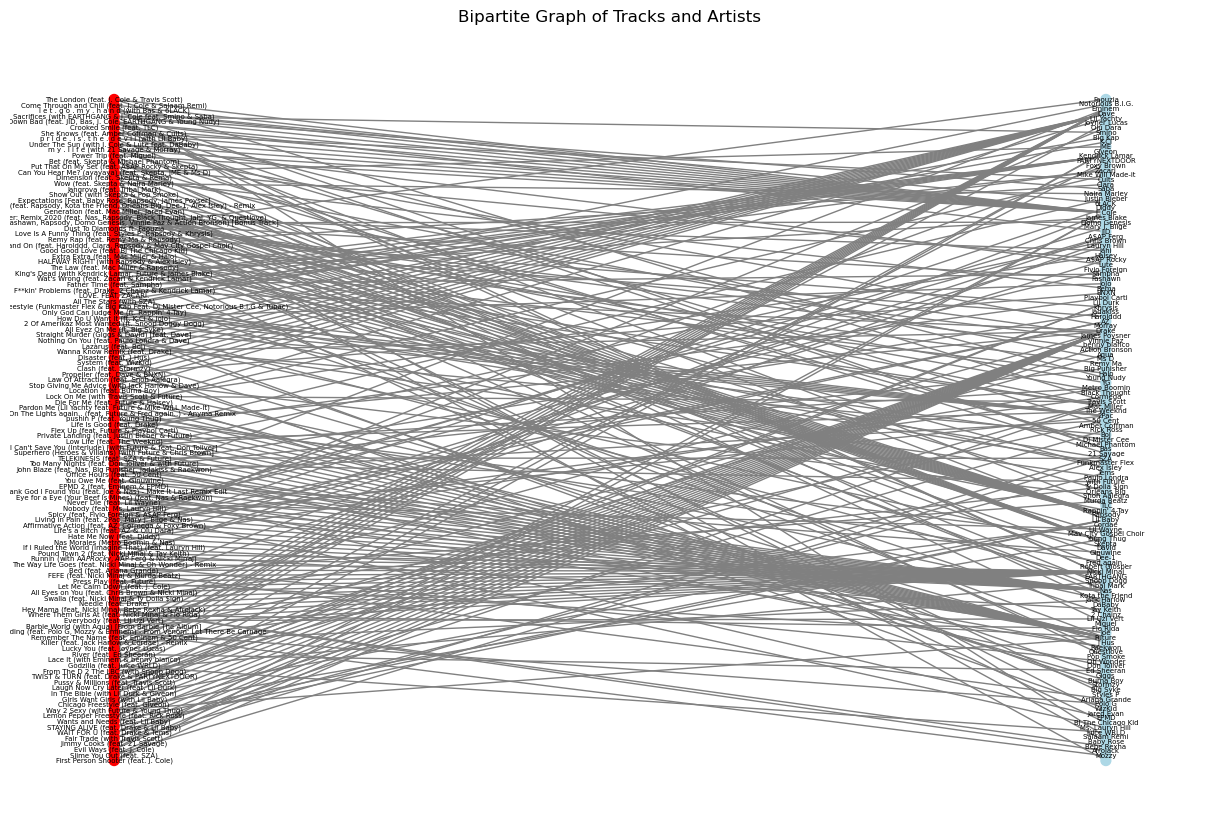

In [12]:
#create a new bipartite graph
G = nx.Graph()

#add nodes with the node attribute "bipartite"
track_nodes = df3['track_name'].tolist()
artist_nodes = set(artist for sublist in df3['all_artists'] for artist in sublist)

G.add_nodes_from(track_nodes, bipartite=0)  #track nodes
G.add_nodes_from(artist_nodes, bipartite=1)  #artist nodes

#add edges between track nodes and their corresponding artist nodes
for index, row in df3.iterrows():
    for artist in row['all_artists']:
        G.add_edge(row['track_name'], artist)

# Display graph
pos = nx.bipartite_layout(G, nodes=track_nodes)

node_colors = ['red' if node in track_nodes else 'lightblue' for node in G.nodes()] #set node colors
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=50, font_size=5)
plt.title("Bipartite Graph of Tracks and Artists")
plt.show()

In [13]:
track_nodes = df3['track_name'].tolist()
artist_nodes = set(artist for sublist in df3['all_artists'] for artist in sublist)

# Create a new bipartite graph
G = nx.Graph()
# Add nodes with the node attribute "bipartite"
G.add_nodes_from(track_nodes, bipartite=0, color='red')  # Track nodes
G.add_nodes_from(artist_nodes, bipartite=1, color='lightblue')  # Artist nodes

# Add edges between track nodes and their corresponding artist nodes
for index, row in df3.iterrows():
    for artist in row['all_artists']:
        G.add_edge(row['track_name'], artist)

# Create a Pyvis network
nt = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")

# Add nodes and edges from the NetworkX graph
for node, node_attrs in G.nodes(data=True):
    nt.add_node(node, title=node, color=node_attrs['color'])

for u, v in G.edges():
    nt.add_edge(u, v)

# Set options for better visualization
nt.set_options("""
var options = {
  "nodes": {
    "font": {
      "size": 12
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -8000,
      "centralGravity": 0.3,
      "springLength": 95,
      "springConstant": 0.04,
      "damping": 0.09,
      "avoidOverlap": 0.1
    },
    "maxVelocity": 50,
    "minVelocity": 0.1,
    "solver": "barnesHut",
    "timestep": 0.5,
    "stabilization": {
      "enabled": true,
      "iterations": 1000
    }
  }
}
""")

# Show the network
nt.show("bipartite_graph.html")

bipartite_graph.html


In [14]:
#Get count of track nodes and artist nodes
track_count = sum(1 for n, d in G.nodes(data=True) if d['bipartite'] == 0)
artist_count = sum(1 for n, d in G.nodes(data=True) if d['bipartite'] == 1)

print(f"There are {track_count} tracks made by {artist_count} artists")

There are 119 tracks made by 141 artists


### 3.2 Examining Connected Components  
This allows for focus to be directed to the largest component of the graph. For this network we have single connected component.

In [15]:
if nx.is_connected(G) == True:
    print("The network has a single connnected component")
else:
    print(f"The network has {nx.number_connected_components(G)} components of sizes: {[len(c) for c in nx.connected_components(nx.Graph(G))]}")

The network has a single connnected component


In [16]:
#Extracting largest connected component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
print(f"No. of Nodes: {len(G0.nodes())}")

No. of Nodes: 260


### 3.3 Create Node Reference Sets

In [17]:
top_nodes, bottom_nodes = nx.bipartite.sets(G0)
print(len(top_nodes)) #tracks
print(len(bottom_nodes)) #artists

119
141


###  3.4 Projecting Bipartite Graph Artist Nodes

In [18]:
#Project bipartite graph onto artist nodes
A = nx.bipartite.weighted_projected_graph(G0, bottom_nodes) #artists set

### 3.5 Extracting Centrality Measures

In [19]:
node_degrees_A = dict(A.degree())
top_nodes_A = set(sorted(node_degrees_A.items(), key=lambda x: x[1], reverse=True)[:20])

print("Member Name - Degree Centrality")
list(sorted(top_nodes_A, key=lambda x: x[1], reverse=True))

Member Name - Degree Centrality


[('Rapsody', 28),
 ('Nas', 27),
 ('J. Cole', 20),
 ('Future', 18),
 ('Drake', 16),
 ('Nicki Minaj', 16),
 ('Eminem', 12),
 ('Dave', 12),
 ('2Pac', 11),
 ('Skepta', 8),
 ('Kendrick Lamar', 7),
 ('Questlove', 6),
 ('EARTHGANG', 6),
 ('Jahi', 6),
 ('Black Thought', 6),
 ('', 6),
 ('YG', 6),
 ('Bas', 5),
 ('Dee-1', 4),
 ('Kota the Friend', 4)]

In [20]:
# Extract centrality measures
dgr = nx.degree_centrality(A)
clo = nx.closeness_centrality(A)
eig = nx.eigenvector_centrality(A)
bet = nx.betweenness_centrality(A)

# Create DataFrame for each centrality measure
df_dgr = pd.DataFrame(list(dgr.items()), columns=['Node', 'Degree']).nlargest(10, 'Degree')
df_clo = pd.DataFrame(list(clo.items()), columns=['Node', 'Closeness']).nlargest(10, 'Closeness')
df_eig = pd.DataFrame(list(eig.items()), columns=['Node', 'Eigenvector']).nlargest(10, 'Eigenvector')
df_bet = pd.DataFrame(list(bet.items()), columns=['Node', 'Betweenness']).nlargest(10, 'Betweenness')

# Assuming each DataFrame has exactly 10 rows
if all(len(df) == 10 for df in [df_dgr, df_clo, df_eig, df_bet]):
    # Merge DataFrames on 'Node' column and handle potential mismatches in index ranges
    top_10_centralities = pd.DataFrame({
        "Degree": df_dgr['Node'].values,
        "Closeness": df_clo['Node'].values,
        "Eigenvector": df_eig['Node'].values,
        "Betweenness": df_bet['Node'].values
    }, index=range(1, 11))  # Set index as 1-indexed for better readability

    # Display the comparison table
    print(top_10_centralities)
else:
    print("Error: Not all DataFrames have 10 rows. Please check the input data.")

         Degree      Closeness      Eigenvector   Betweenness
1       Rapsody            Nas          Rapsody           Nas
2           Nas    Nicki Minaj              Nas   Nicki Minaj
3       J. Cole      A$AP Ferg                        Rapsody
4        Future         Future        Questlove     A$AP Ferg
5   Nicki Minaj   Metro Boomin    Black Thought        Future
6         Drake          Drake               YG       J. Cole
7          Dave     A$AP Rocky             Jahi         Drake
8        Eminem         Eminem  Kota the Friend        Eminem
9          2Pac        Rapsody            Dee-1          Dave
10       Skepta  Fivio Foreign      Orleans Big  Metro Boomin


### 3.6 View Network Graph For Largest Component

In [21]:
#create pyvis network
nt = Network(notebook=True, height="750px", width="100%")
#add nodes with size based on degree centrality
for node in A.nodes():
    nt.add_node(node, size=dgr[node] * 100, title=str(dgr[node]))

#add edges
for u, v, data in A.edges(data=True):
    nt.add_edge(u, v, value=data['weight'])

# Set options for the layout
nt.set_options("""
var options = {
  "nodes": {
    "font": {
      "size": 12
    }
  },
  "edges": {
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "physics": {
    "forceAtlas2Based": {
      "gravitationalConstant": -26,
      "centralGravity": 0.005,
      "springLength": 230,
      "springConstant": 0.18
    },
    "maxVelocity": 146,
    "solver": "forceAtlas2Based",
    "timestep": 0.35,
    "stabilization": {"iterations": 150}
  }
}
""")

# Show the network
nt.show("network.html")

network.html


### 3.7 Community Detection (Blocks based on clusters)

In [22]:
#detect communities
partition = community_louvain.best_partition(A)

# Initialize Pyvis network; set notebook to True to display within a Jupyter notebook
nt = Network(notebook=True, height="750px", width="100%")
nt.barnes_hut()

# Map each node to its cluster color
cluster_colors = {node: f"hsl({partition[node] * 100 % 360}, 100%, 70%)" for node in A.nodes()}

# Add nodes with color based on their partition
for node in A.nodes:
    nt.add_node(node, title=f"Node: {node}", color=cluster_colors[node])

# Add edges
for edge in A.edges:
    nt.add_edge(edge[0], edge[1])

# Set the physics simulation options to make clusters more evident
nt.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -8000,
      "centralGravity": 0.3,
      "springLength": 95,
      "springConstant": 0.04,
      "damping": 0.09,
      "avoidOverlap": 0.1
    },
    "maxVelocity": 50,
    "minVelocity": 0.1,
    "solver": "barnesHut",
    "timestep": 0.5,
    "stabilization": {
      "enabled": true,
      "iterations": 1000
    }
  }
}
""")

# Show the network
nt.show("network.html")

network.html


# 4. NLP Analysis  

For sentiment analysis, the Textblob library is used. It provides an easy to use interface to identify polarity value of sentiment in a token. For topic detection, gensim library is used to identify 10 different topics. Latent Dirichlet Allocation (LDA) was executed to model the topics. LDA works by taking the counts found in a vector of words and assigns a probability. Although the model executed identifying 10 topics, it did not extract useful information. This can be attributed to the genres lingo and unique speech patterns. The topic results are not promising, as such other topic detection techniques should be explored including the creation of a unique corpus of stop words for rap music.

### 4.1 Sentiment Detection

In [23]:
#define polarity function for determining sentiment
# Sentiment analysis function
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'


#get sentiment
df2['sentiment1'] = df2['raw_lyrics'].apply(get_sentiment)
df2.head()

,track_name,artist,raw_lyrics,artist_verses,featured_artists,all_artists,sentiment1
0,You Broke My Heart,Drake,"Yeah Yeah Oh, baby, don't go Don't go Look Loo...","Yeah\nYeah\nOh, baby, don't go\nDon't go\nLook...",[],[Drake],Negative
1,First Person Shooter (feat. J. Cole),Drake,"[Intro: J. Cole & Adonis] (Pew, pew-pew) First...",Big as the what? (Ah)\nBig as the what? (Mm)\n...,[J. Cole],"[Drake, J. Cole]",Negative
2,MELTDOWN (feat. Drake),Drake,[Intro: Drake] Yeah Tensions is definitely ris...,Yeah\nTensions is definitely rising\nT'd up ri...,[],[Drake],Negative
3,Slime You Out (feat. SZA),Drake,I don't know I don't know what's wrong with yo...,I don't know\nI don't know what's wrong with y...,[SZA],"[Drake, SZA]",Negative
4,On The Radar Freestyle,Drake,"Yeah On The Radar, 2023 6 G-O-D and my broski ...","Yeah\nOn The Radar, \n G-O-D and my broski \nC...",[],[Drake],Negative


### 4.2 Topic Detection

In [24]:
#retrieve wordent and stopwords from nltk
# nltk.download('wordnet')
# nltk.download('stopwords')

stopwords_set = set(STOPWORDS)
additional_stopwords = {'yeah', 'uh', 'oh', 'ha', 'like', 'gonna', 'gotta', 'chorus', 'verse', 'ft', 'nigga', 'niggas', 'remix', 'feat'}
stopwords_set = stopwords_set.union(additional_stopwords)
flattened_artists = [artist for sublist in df2['all_artists'] for artist in sublist]
stopwords_set.update(flattened_artists)

#preprocess lyrics by removing stopwords
def preprocess(text):
    return [token for token in simple_preprocess(text) if token not in stopwords_set]

processed_lyrics = df2['raw_lyrics'].map(preprocess)
processed_lyrics[:5]

0    [baby, look, look, notepad, caught, bodies, sc...
1    [intro, cole, adonis, pew, pew, pew, person, s...
2    [intro, drake, tensions, definitely, rising, r...
3    [know, know, wrong, girls, feel, need, love, n...
4    [radar, broski, know, madness, badness, combin...
Name: raw_lyrics, dtype: object

In [25]:
#create corpus from processed_lyrics
dictionary = corpora.Dictionary(processed_lyrics)
corpus = [dictionary.doc2bow(text) for text in processed_lyrics]

In [26]:
#train lda model
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10)

In [27]:
#get topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.033*"la" + 0.015*"hol" + 0.010*"got" + 0.007*"bitch" + 0.006*"da" + 0.006*"sit" + 0.006*"day" + 0.005*"girls" + 0.005*"know" + 0.005*"ayy"')
(1, '0.006*"play" + 0.006*"got" + 0.006*"ain" + 0.005*"lil" + 0.005*"real" + 0.005*"press" + 0.005*"fuck" + 0.005*"em" + 0.005*"bitch" + 0.005*"right"')
(2, '0.007*"ain" + 0.007*"boom" + 0.006*"eminem" + 0.005*"got" + 0.005*"stop" + 0.005*"tryin" + 0.005*"love" + 0.004*"superman" + 0.004*"let" + 0.004*"lil"')
(3, '0.024*"know" + 0.018*"got" + 0.013*"love" + 0.012*"cause" + 0.010*"wanna" + 0.009*"want" + 0.008*"baby" + 0.008*"ain" + 0.006*"man" + 0.006*"time"')
(4, '0.013*"man" + 0.012*"know" + 0.011*"got" + 0.010*"woah" + 0.007*"ain" + 0.007*"tell" + 0.007*"wanna" + 0.006*"time" + 0.006*"ooh" + 0.006*"love"')
(5, '0.012*"got" + 0.010*"know" + 0.007*"man" + 0.007*"time" + 0.007*"shit" + 0.007*"love" + 0.006*"kendrick" + 0.006*"fuck" + 0.006*"lamar" + 0.006*"ain"')
(6, '0.015*"got" + 0.012*"ain" + 0.010*"shit" + 0.009*"know" + 0.007*"fuck" + 

In [28]:
#assign main topic to each observation
def get_topic(text):
    bow = dictionary.doc2bow(text)
    topics = lda_model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]

df2['topic'] = processed_lyrics.map(get_topic)

In [29]:
df2.head()

,track_name,artist,raw_lyrics,artist_verses,featured_artists,all_artists,sentiment1,topic
0,You Broke My Heart,Drake,"Yeah Yeah Oh, baby, don't go Don't go Look Loo...","Yeah\nYeah\nOh, baby, don't go\nDon't go\nLook...",[],[Drake],Negative,6
1,First Person Shooter (feat. J. Cole),Drake,"[Intro: J. Cole & Adonis] (Pew, pew-pew) First...",Big as the what? (Ah)\nBig as the what? (Mm)\n...,[J. Cole],"[Drake, J. Cole]",Negative,6
2,MELTDOWN (feat. Drake),Drake,[Intro: Drake] Yeah Tensions is definitely ris...,Yeah\nTensions is definitely rising\nT'd up ri...,[],[Drake],Negative,3
3,Slime You Out (feat. SZA),Drake,I don't know I don't know what's wrong with yo...,I don't know\nI don't know what's wrong with y...,[SZA],"[Drake, SZA]",Negative,5
4,On The Radar Freestyle,Drake,"Yeah On The Radar, 2023 6 G-O-D and my broski ...","Yeah\nOn The Radar, \n G-O-D and my broski \nC...",[],[Drake],Negative,3


/tmp/ipykernel_42497/3999032201.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')


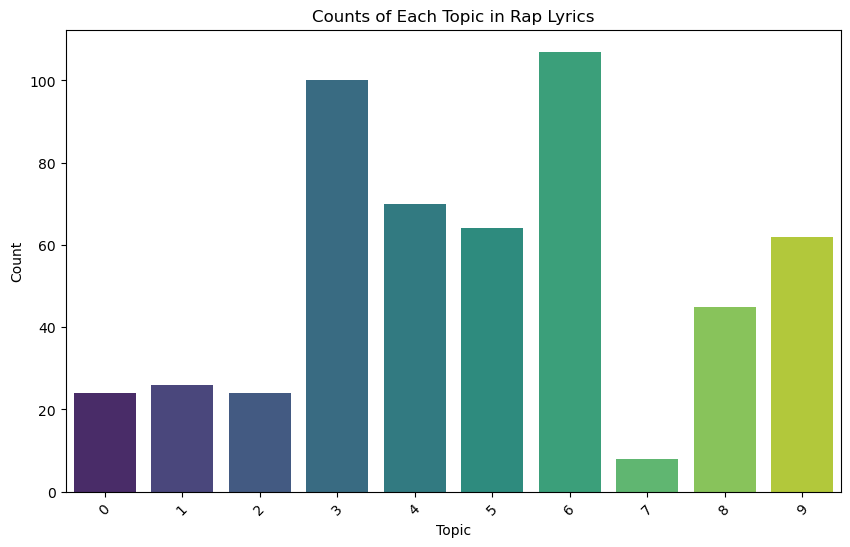

In [30]:
#Get count of each topic
topic_counts = df2['topic'].value_counts()

#plot
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette='viridis')
plt.title('Counts of Each Topic in Rap Lyrics')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [31]:
#save df for network analysis
df2.to_csv('data/rap_lyrics_with_sentiment_and_topic_detections.csv', index=False)
